In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

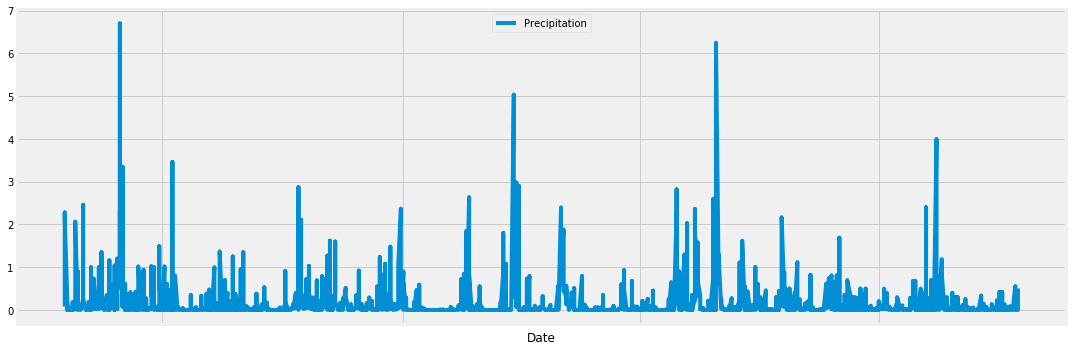

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results#
# Calculate the date 1 year ago from the last data point in the database#
# Perform a query to retrieve the data and precipitation scores#
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data


max_date = max(session.query(measurement.date))[0]

start_date = datetime.strptime(max_date, '%Y-%m-%d').date()

year_ago = start_date - dt.timedelta(days=365)

data = session.query(measurement.date,measurement.prcp).filter(measurement.prcp!='None').filter(measurement.date >year_ago).filter(measurement.date<start_date).all()


prcp = pd.DataFrame(data).set_index('date').rename(columns = {'prcp':'Precipitation'}).sort_values('date')

didx = pd.date_range(start =min(prcp.index), freq ='Q',periods = 4)
quarts = [x.strftime("%Y-%m-%d") for x in didx]


# create table
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1)     
plt.plot(prcp.Precipitation, label = 'Precipitation')

# Set major xticks to quarter
ax.set_xticks(quarts, minor = False)

#set gridlines and labels
ax.grid(which = 'major', axis = 'both',alpha = 1)
# plt.ylabel('Precipitation')
plt.xlabel('Date')
ax.set_xticklabels([])
plt.tight_layout()
ax.legend(loc = 'upper center')
plt.savefig('../hw_images/Precipitation_BB.png')
plt.show();

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp.describe()

,Precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

<h1>Station Analysis</h1>

In [14]:
# Design a query to show how many stations are available in this dataset?


<h2>Most Active Station</h2>

In [27]:
# Design a query to show how many stations are available in this dataset?
Total_stations = session.query(func.count(station.station)).all()
Total_stations[0][0]

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations = session.query(measurement.station, func.count(measurement.date)).group_by('station').order_by(func.count(measurement.date).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
mactive = stations[0][0]
print(f'The most active station is: {mactive}')

The most active station is: USC00519281


In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp = measurement.tobs

session.query(func.min(temp),func.max(temp),func.avg(temp)).filter(measurement.station == mactive).all()


[(54.0, 85.0, 71.66378066378067)]

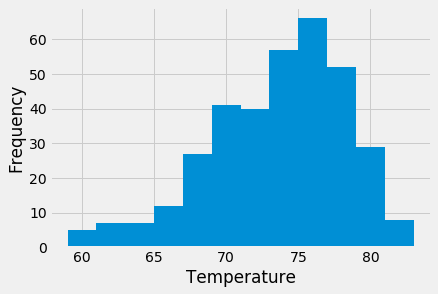

In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram



max_date2 = max(session.query(measurement.date).filter(measurement.station == mactive))[0]
# max_date2
start_date2 = datetime.strptime(max_date2, '%Y-%m-%d').date()

year_ago2 = start_date2 - dt.timedelta(days=365)

# print('start date: ',max_date)
# print('year ago',year_ago)


temp_LastYear = session.query(measurement.date,temp).filter(measurement.station == mactive).filter(measurement.date>year_ago).filter(measurement.date<max_date).all()

temp_df = pd.DataFrame(temp_LastYear,columns = ['Date','Temp'])


plt.hist(temp_df['Temp'],label = 'Temp', bins = 12);
plt.tight_layout()
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

<h2>Climate App</h2>

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps(year_ago,max_date))


[(58.0, 74.59058295964125, 87.0)]


In [35]:
temp_df.head()

,Date,Temp
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


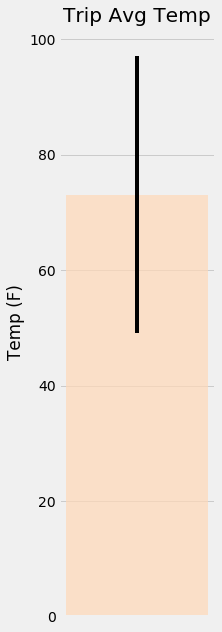

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


y = temp_df['Temp'].mean()
yerr = temp_df.Temp.max() - temp_df.Temp.min()

fig = plt.figure(figsize=(3,9))
ax = fig.add_subplot(1, 1, 1)  
plt.bar(range(1),y, yerr = yerr, label = 'Temp', color =[(1,.85,.72)],alpha = 0.7);
ax.set_xticklabels([])
plt.title("Trip Avg Temp")
plt.tight_layout()
plt.ylabel('Temp (F)')
plt.grid(axis = 'x')
plt.show()

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)




In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(measurement.station, station.latitude, station.longitude,station.elevation,func.sum(measurement.prcp)).filter(measurement.date>year_ago).filter(measurement.date<max_date).filter(measurement.station == station.station).group_by('station').order_by(func.sum(measurement.prcp).desc()).all()
print(rainfall)

[('USC00516128', 21.3331, -157.8025, 152.4, 146.66000000000005), ('USC00519281', 21.45167, -157.84888999999998, 32.9, 68.24000000000002), ('USC00513117', 21.4234, -157.8015, 14.6, 48.36000000000003), ('USC00519523', 21.33556, -157.71139, 19.5, 37.910000000000004), ('USC00514830', 21.5213, -157.8374, 7.0, 33.19), ('USC00519397', 21.2716, -157.8168, 3.0, 16.089999999999986), ('USC00517948', 21.3934, -157.9751, 11.9, 4.59)]


In [39]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [41]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip

start_date = datetime.strptime(max_date, '%Y-%m-%d').date()
end_date =  start_date - dt.timedelta(days=10)

# Use the start and end date to create a range of dates
dates = session.query(measurement.date).filter(measurement.date<start_date).filter(measurement.date>end_date).all()


# Strip off the year and save a list of %m-%d strings

datez = [date[0] for date in dates]

for date in datez:
    x = datetime.strptime(date,'%Y-%m-%d')
    normals.append(daily_normals(x.strftime('%m-%d')))


# Loop through the list of %m-%d strings and calculate the normals for each date




In [42]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings


# Loop through the list of %m-%d strings and calculate the normals for each date


In [43]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

tmin = [x[0][0] for x in normals]
tavg = [x[0][1] for x in normals]
tmax = [x[0][2] for x in normals]

data = {'date':datez,
       'tmin':tmin,
       'tavg':tavg,
       'tmax':tmax}
trip_df = pd.DataFrame(data).set_index('date')

df2 = trip_df[0:11]
trip_df.head()

,tmin,tavg,tmax
date,,,
2017-08-14,71.0,76.777778,82.0
2017-08-15,69.0,76.471698,83.0
2017-08-18,70.0,76.923077,84.0
2017-08-19,69.0,75.946429,85.0
2017-08-20,68.0,76.452830,82.0


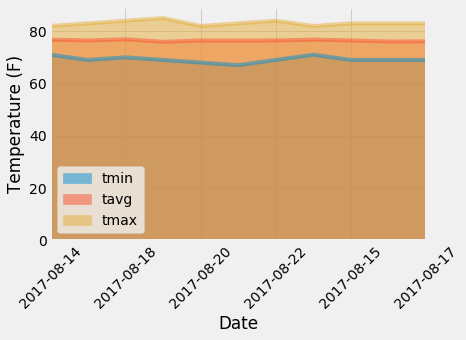

In [45]:

df2.plot.area(stacked = False)
plt.legend(loc='lower left')
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.show()


In [326]:
# Plot the daily normals as an area plot with `stacked=False`
